In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

import re
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_model_report(y_actual, y_pred):
    print("Accuracy:", accuracy_score(y_actual, y_pred))
    print("Precision:", precision_score(y_actual, y_pred, average='weighted')) # 'micro', 'macro'
    print("Recall:", recall_score(y_actual, y_pred, average='weighted'))
    print("F1 score:", f1_score(y_actual, y_pred, average='weighted'))

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.shape

(5572, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [8]:
df.dropna(how='any', axis=1, inplace=True)
df.columns=['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Cleaning

In [9]:
df['nChars'] = df['message'].apply(len)
#df["nWords"]=df.apply(lambda row: nltk.word_tokenize(row["message"]), axis=1).apply(len)
#df["nSent"]=df.apply(lambda row: nltk.sent_tokenize(row["message"]), axis=1).apply(len)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
nChars,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0


<Figure size 600x500 with 0 Axes>

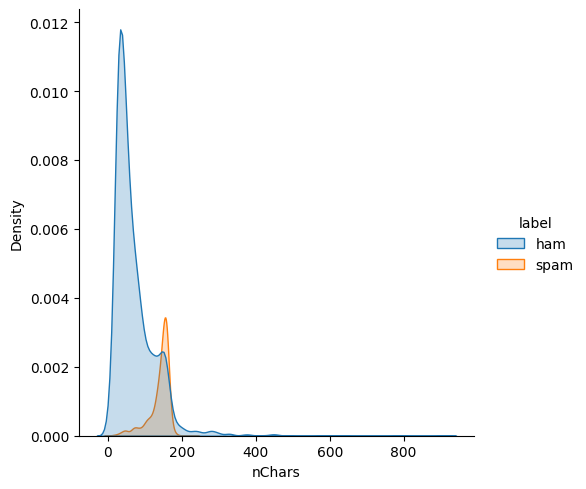

In [10]:
plt.figure(figsize=(6,5))
fg = sns.displot(df, x='nChars', hue="label", kind="kde", fill=True)
plt.show(fg)

In [11]:
data = df[(df["nChars"]<300)]
data.describe().T

,count,mean,std,min,25%,50%,75%,max
nChars,5536.0,77.841402,51.624803,2.0,35.0,60.0,120.0,299.0


<Figure size 600x500 with 0 Axes>

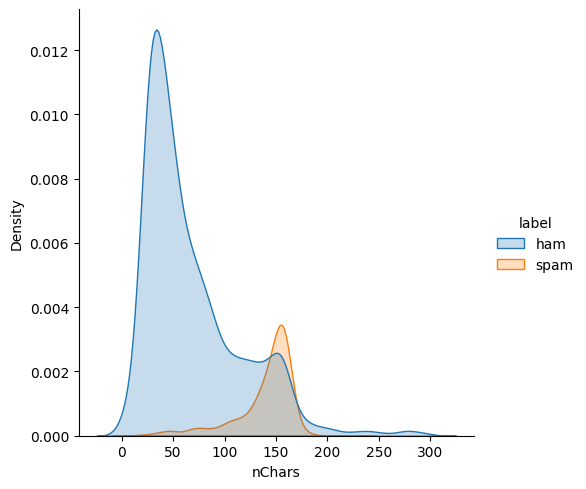

In [12]:
plt.figure(figsize=(6,5))
fg = sns.displot(data, x='nChars', hue="label", kind="kde", fill=True)
plt.show(fg)

In [13]:
data.head()

,label,message,nChars
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<Axes: xlabel='label', ylabel='count'>

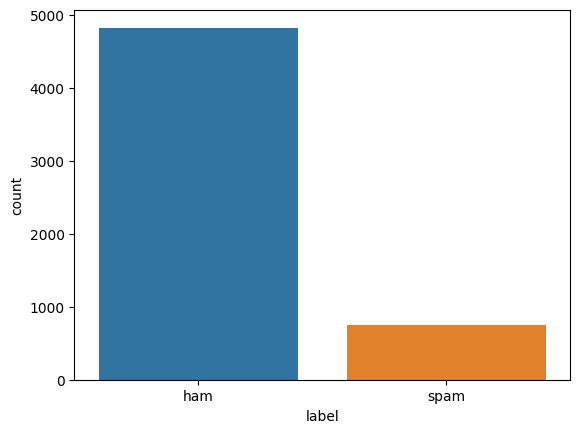

In [14]:
sns.countplot(x=df['label'])

## Data Preprocessing

In [15]:
wordnet = WordNetLemmatizer()

def cleaner(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub('[^a-zA-Z]', ' ', text.lower())
    text = ' '.join([wordnet.lemmatize(word) for word in text.split() if not word in stop_words])
    return text

df['clean_msg'] = df['message'].apply(cleaner)

In [16]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,message,nChars,clean_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think go usf life around though


In [17]:
df.isna().any()

label        False
message      False
nChars       False
clean_msg    False
dtype: bool

# Model

In [18]:
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df['clean_msg'].to_numpy())
y = df['label'].values

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0)
print('x_train size: {}, x_test size: {}'.format(x_train.shape, x_test.shape))

x_train size: (3900, 7021), x_test size: (1672, 7021)


### SGD Classifier

In [20]:
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
%time svm.fit(x_train, y_train)

CPU times: user 3.99 ms, sys: 0 ns, total: 3.99 ms
Wall time: 3.66 ms


SGDClassifier(alpha=0.001, random_state=42)

In [21]:
y_pred_1 = svm.predict(x_test)

In [22]:
generate_model_report(y_test, y_pred_1)
print("Classification Report:\n", classification_report(y_test, y_pred_1))

Accuracy: 0.9647129186602871
Precision: 0.9658507097463314
Recall: 0.9647129186602871
F1 score: 0.9626565462339862
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1434
           1       0.99      0.76      0.86       238

    accuracy                           0.96      1672
   macro avg       0.98      0.88      0.92      1672
weighted avg       0.97      0.96      0.96      1672



### Multinomial Naive Bayes

In [23]:
nb_classifier = MultinomialNB()
%time nb_classifier.fit(x_train, y_train)

CPU times: user 886 µs, sys: 944 µs, total: 1.83 ms
Wall time: 1.62 ms


MultinomialNB()

In [24]:
y_pred_2 = nb_classifier.predict(x_test)

In [25]:
generate_model_report(y_test, y_pred_2)
print("Classification Report:\n", classification_report(y_test, y_pred_2))

Accuracy: 0.9575358851674641
Precision: 0.9595391756346469
Recall: 0.9575358851674641
F1 score: 0.9543266434433617
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      1434
           1       1.00      0.70      0.82       238

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.95      1672



## Conclusion

In summary, the SGD Classifier and Multinomial NB models deliver consistent and strong performance for the task, with all evaluation metrics, including accuracy, precision, recall, and F1-score, standing at a solid 0.96. These identical high scores indicate that both models are equally well-suited for the task, showcasing excellent classification capabilities.